<a href="https://colab.research.google.com/github/irfanfarid02/irfan-resolusi/blob/main/revisi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library yang diperlukan

import pandas as pd
import re
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
import matplotlib.pyplot as plt
import seaborn as sns
!pip install -q pandas sastrawi scikit-learn
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import files
import nltk

# Download stopwords untuk Bahasa Indonesia
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))
from IPython.display import display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.9 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load dataset dari file CSV
data = pd.read_csv('/content/23510reviewchatgpt.csv', encoding='latin1', delimiter=';')
print(data.head())

   Column1                                            content
0    12916  Untuk pencipta apk ini terimah kasih yah Sudah...
1    12364                                              bagus
2    12964                                 keren banget dah ?
3    12205  Lumayan bagus sih, hanya saja mungkin untuk tu...
4    12470                                       Sangat bagus


In [ ]:
data=data[['content']]
data.head()

,content
0,Untuk pencipta apk ini terimah kasih yah Sudah...
1,bagus
2,keren banget dah ?
3,"Lumayan bagus sih, hanya saja mungkin untuk tu..."
4,Sangat bagus


In [ ]:
# Hapus baris yang memiliki nilai NaN pada kolom 'content'
data.dropna(axis=0, subset=['content'], inplace=True)

In [ ]:
missing_info = pd.DataFrame({
    'missing_values': data.isnull().sum(),
    'percent_missing': data.isnull().mean() * 100
})
missing_info

,missing_values,percent_missing
content,0,0.0


In [ ]:
# Menghitung panjang dalam jumlah kata
data['panjang_kata'] = data['content'].apply(lambda x: len(x.split()))

# Menghitung panjang dalam jumlah karakter
data['panjang_karakter'] = data['content'].apply(len)


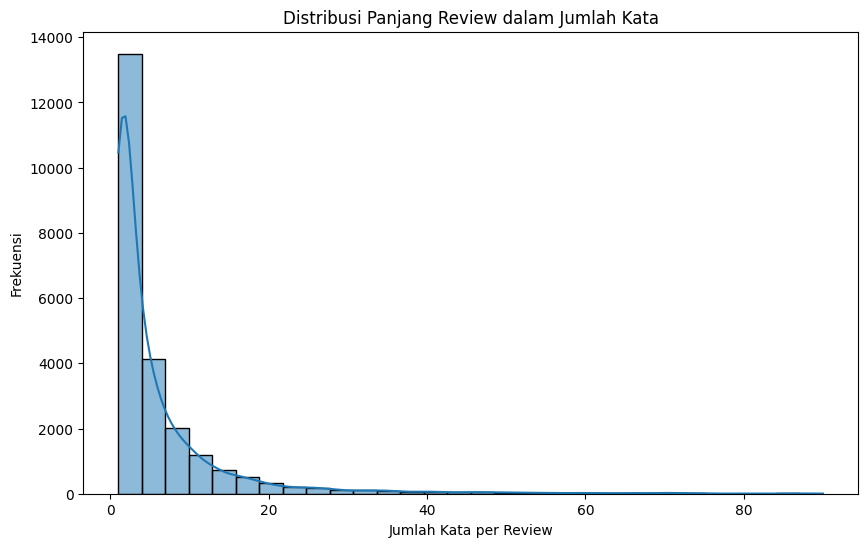

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(data['panjang_kata'], bins=30, kde=True)
plt.xlabel('Jumlah Kata per Review')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Review dalam Jumlah Kata')
plt.show()


preprocessing

In [ ]:
# Inisialisasi stemmer dari Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Load lexicon for sentiment analysis (lexicon sentimen indo)
positive_lexicon = pd.read_csv('positive.tsv', sep='\t')
negative_lexicon = pd.read_csv('negative.tsv', sep='\t')

# Membuat kamus kata positif dan negatif untuk lookup
positive_dict = dict(zip(positive_lexicon['word'], positive_lexicon['weight']))
negative_dict = dict(zip(negative_lexicon['word'], negative_lexicon['weight']))

In [ ]:
#Define slang normalization dictionary
slang_dict = {
    "gak": "tidak", "gbs": "tidak bisa", "gk": "tidak", "nggak": "tidak",
    "udah": "sudah", "aja": "saja", "mau": "ingin", "gue": "saya", "klo": "kalau",
    "tp": "tapi", "tpi": "tapi", "sy": "saya", "anjayyy ": "wah ", "ngulang": "mengulang",
    "btw": "ngomong-ngomong", "tp": "tapi", "sy": "saya", "anjayyy ": "wah ",
    "ngulang": "mengulang", "yaa": "iya", "njay": " ", "mantaf": "mantap",
    "fokoknyah": "pokoknya", "gaada": "tidak ada", "gamau": "tidak mau",
    "pke": "pakai", "yg": "yang", "tu": "itu", "kyk": "seperti", "udh": "sudah",
    "lgi": "lagi", "trus": "terus", "udh": "sudah", "nyoba": "mencoba", "msi": "masih",
    "untk": "untuk",
}

In [ ]:
# Fungsi preprocessing
def case_folding(content):
    return content.lower()

def normalize_slang(content):
    for slang, replacement in slang_dict.items():
        content = re.sub(r'\b' + slang + r'\b', replacement, content)
    return content

def remove_stopwords(content):
    return ' '.join([word for word in content.split() if word not in stop_words])

def stem_words(content):
    return ' '.join([stemmer.stem(word) for word in content.split()])

def tokenize_content(content):
    return content.split()


In [ ]:
# Proses preprocessing pada seluruh data menggunakan swifter
!pip install swifter
import swifter
import time

def preprocess_data_swifter(df):
    # Memanfaatkan swifter untuk mempercepat proses
    return df['content'].swifter.apply(lambda x: {
        "Hasil Case Folding": case_folding(x),
        "Hasil Normalisasi Slang Word": normalize_slang(case_folding(x)),
        "Hasil Stopword Removal": remove_stopwords(normalize_slang(case_folding(x))),
        "Hasil Stemming": stem_words(remove_stopwords(normalize_slang(case_folding(x)))),
        "Hasil Tokenisasi": tokenize_content(stem_words(remove_stopwords(normalize_slang(case_folding(x))))),
    })

# Menerapkan preprocessing ke seluruh data dan menghitung waktu
start_time = time.time()

# Proses seluruh data dengan swifter untuk mempercepat aplikasi
df_processed = preprocess_data_swifter(data)

# Catat waktu selesai pemrosesan
end_time = time.time()

# Hitung dan tampilkan waktu pemrosesan
processing_time = end_time - start_time
print(f"Processing time: {processing_time:.2f} seconds")

# Tampilkan hasil
print("Hasil Preprocessing untuk Semua Data:")
display(df_processed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 17.7 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=e3b7bf5b35d16e90d2f4508aac97927330aa29b81849d5b553e5cb9cccc3b951
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


Pandas Apply:   0%|          | 0/23508 [00:00<?, ?it/s]

Processing time: 1089.83 seconds
Hasil Preprocessing untuk Semua Data:


,content
0,{'Hasil Case Folding': 'untuk pencipta apk ini...
1,"{'Hasil Case Folding': 'bagus', 'Hasil Normali..."
2,"{'Hasil Case Folding': 'keren banget dah ?', '..."
3,"{'Hasil Case Folding': 'lumayan bagus sih, han..."
4,"{'Hasil Case Folding': 'sangat bagus', 'Hasil ..."
...,...
23504,{'Hasil Case Folding': 'tapi login nya nggak j...
23505,"{'Hasil Case Folding': 'ngeleg', 'Hasil Normal..."
23506,{'Hasil Case Folding': 'update pengetahuan nya...
23507,{'Hasil Case Folding': 'kurang tepat untuk men...


In [ ]:
# Ubah hasil preprocessing menjadi DataFrame (menggunakan apply(pd.Series))
df_processed_expanded = df_processed.apply(pd.Series)

# Menemukan dua baris dengan teks terpanjang setelah preprocessing
longest_case_folding = df_processed_expanded['Hasil Case Folding'].apply(len).nlargest(2)

# Ambil index baris terpanjang
longest_case_foldings_idx = longest_case_folding.index

# Menampilkan dua contoh data terpanjang pada setiap langkah preprocessing
print("Contoh Dua Data Terpanjang:")

# Menampilkan hasil preprocessing untuk dua data terpanjang
for idx in longest_case_foldings_idx:
    print(f"\nTeks Terpanjang pada Index {idx}:\n")

    # Mengambil hasil preprocessing untuk setiap kolom
    case_folding = df_processed_expanded.iloc[idx]['Hasil Case Folding']
    normalisasi_slang = df_processed_expanded.iloc[idx]['Hasil Normalisasi Slang Word']
    stopword_removal = df_processed_expanded.iloc[idx]['Hasil Stopword Removal']
    stemming = df_processed_expanded.iloc[idx]['Hasil Stemming']
    tokenisasi = df_processed_expanded.iloc[idx]['Hasil Tokenisasi']

    # Menampilkan hasil dengan format yang lebih rapi
    print(f"1. Hasil Case Folding: \n{case_folding}\n")
    print(f"2. Hasil Normalisasi Slang Word: \n{normalisasi_slang}\n")
    print(f"3. Hasil Stopword Removal: \n{stopword_removal}\n")
    print(f"4. Hasil Stemming: \n{stemming}\n")
    print(f"5. Hasil Tokenisasi: \n{tokenisasi}\n")  # Menampilkan tokenisasi sebagai array


Contoh Dua Data Terpanjang:

Teks Terpanjang pada Index 4829:

1. Hasil Case Folding: 
terimakasih untuk semuanya , saya bisa sambil belajar bahasa asing di dalam aplikasi ini . saya tidak merasakan ada kekurangan di sini dan saya rasa ini sudah sangat membantu saya pribadi dalam belajar . apalagi ini aplikasi yg tidak diwajibkan berbayar, saya tidak apa apa dengan aplikasi yg usang atau tertinggal. karena saya bukan dalam jajaran kapitalisme yang memiliki sumber daya secara langsung ,saya berada pada jajaran bawah yg terkadang berfikir untk belajar namun ada beberapa keterbatasan

2. Hasil Normalisasi Slang Word: 
terimakasih untuk semuanya , saya bisa sambil belajar bahasa asing di dalam aplikasi ini . saya tidak merasakan ada kekurangan di sini dan saya rasa ini sudah sangat membantu saya pribadi dalam belajar . apalagi ini aplikasi yang tidak diwajibkan berbayar, saya tidak apa apa dengan aplikasi yang usang atau tertinggal. karena saya bukan dalam jajaran kapitalisme yang memiliki

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['content'].values)
data['tokenized_content'] = tokenizer.texts_to_sequences(data['content'].values)

In [ ]:
# Sentiment Analysis Stages
sentiment_cache = {}

def get_sentiment(content):
    if content in sentiment_cache:
        return sentiment_cache[content]

    content_stemmed = stem_words(content)  # Apply stemming

    score = 0
    for word in content_stemmed.split():
        if word in positive_dict:
            score += positive_dict[word]
        elif word in negative_dict:
            score += negative_dict[word]

    # Step 3: Labeling Sentiment
    if score > 0:
        sentiment = 'Positive'
    elif score < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    sentiment_cache[content] = sentiment
    return sentiment

data['sentiment'] = data['content'].apply(get_sentiment)

In [ ]:
# Tampilkan pembagian data berdasarkan sentimen
sentiment_counts = data['sentiment'].value_counts()

# Menampilkan hasil pembagian
print("Hasil Pembagian Data Berdasarkan Sentimen:")
print(sentiment_counts)


Hasil Pembagian Data Berdasarkan Sentimen:
sentiment
Positive    17905
Neutral      3396
Negative     2207
Name: count, dtype: int64


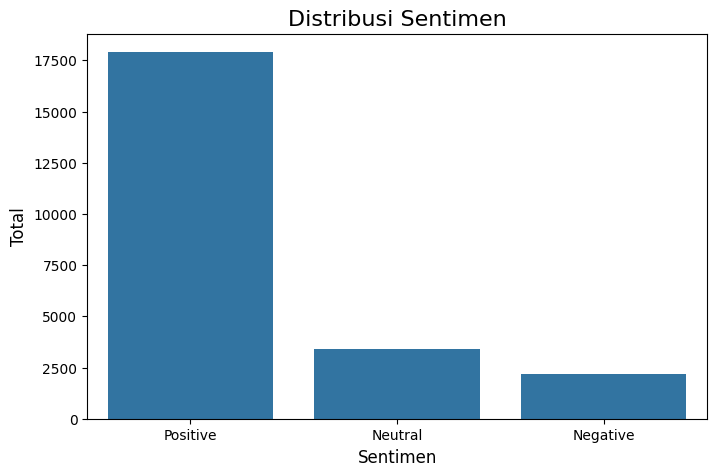

In [ ]:
# Membuat figure dan plot dengan ukuran yang sesuai
plt.figure(figsize=(8, 5))

# Plot distribusi sentimen dengan countplot
sns.countplot(x='sentiment', data=data)

# Menambahkan judul dan label
plt.title('Distribusi Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Total', fontsize=12)

# Menampilkan plot
plt.show()

In [ ]:
# Neural Network Preparation
X = tokenizer.texts_to_sequences(data['content'].values)
X = pad_sequences(X, maxlen=250)
y = pd.get_dummies(data['sentiment']).values

In [ ]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18806, 250) (18806, 3)
(4702, 250) (4702, 3)


In [ ]:
# Hasil Pembagian Dataset
print(f"Total data training: {len(X_train)}, Data testing: {len(X_test)}")
print(f"Total data: {len(data)}")


Total data training: 18806, Data testing: 4702
Total data: 23508


In [ ]:
# Model architecture
model = Sequential()
model.add(Embedding(5000, 100, input_length=250))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(80, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3, min_delta=0.0001)

# Train model
history = model.fit(X_train, y_train, epochs=7, batch_size=128, validation_split=0.2, callbacks=[early_stop])
print (model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 93s 721ms/step - accuracy: 0.7680 - loss: 0.6579 - val_accuracy: 0.8934 - val_loss: 0.2971
Epoch 2/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 133s 660ms/step - accuracy: 0.9088 - loss: 0.2470 - val_accuracy: 0.9242 - val_loss: 0.2166
Epoch 3/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 79s 632ms/step - accuracy: 0.9534 - loss: 0.1427 - val_accuracy: 0.9375 - val_loss: 0.1805
Epoch 4/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 644ms/step - accuracy: 0.9748 - loss: 0.0846 - val_accuracy: 0.9474 - val_loss: 0.1703
Epoch 5/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 85s 673ms/step - accuracy: 0.9813 - loss: 0.0632 - val_accuracy: 0.9431 - val_loss: 0.1778
Epoch 6/7
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 658ms/step - accuracy: 0.9868 - loss: 0.0455 - val_accuracy: 0.9482 - val_loss: 0.1730
Epoch 7/7
 40/118 ━━━━━━━━━━━━━━━━━━━━ 46s 592ms/step - accuracy: 0.9884 - loss: 0.0458

In [ ]:
# Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [ ]:
# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))

# Accuracy
print(f"LSTM Accuracy: {accuracy_score(y_test_classes, y_pred_classes):.4f}")

In [ ]:
# Laporan klasifikasi
class_report = classification_report(y_test_classes, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:")
print(class_report)



In [ ]:
# Visualisasi distribusi sentimen
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment', data=data, palette='Set2')
plt.title('Distribusi Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)
plt.show()

In [ ]:
# Menambahkan kolom panjang teks
data['length'] = data['content'].apply(len)

# Visualisasi distribusi panjang teks berdasarkan sentimen
plt.figure(figsize=(10,6))
sns.boxplot(x='sentiment', y='length', data=data, palette='Set2')
plt.title('Distribusi Panjang Teks Berdasarkan Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=14)
plt.ylabel('Panjang Teks (Jumlah Karakter)', fontsize=14)
plt.show()


In [ ]:
def get_sentiment_score(content):
    content_stemmed = stem_words(content)

    score = 0
    for word in content_stemmed.split():
        if word in positive_dict:
            score += positive_dict[word]
        elif word in negative_dict:
            score += negative_dict[word]

    return score

# Menambahkan skor sentimen ke dalam dataframe
data['sentiment_score'] = data['content'].apply(get_sentiment_score)

# Visualisasi distribusi skor sentimen
plt.figure(figsize=(10,6))
sns.histplot(data['sentiment_score'], kde=True, color='blue')
plt.title('Distribusi Skor Sentimen', fontsize=16)
plt.xlabel('Skor Sentimen', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.show()


In [ ]:
# Menghasilkan confusion matrix
data['predicted_sentiment'] = data['content'].apply(get_sentiment)
cm = confusion_matrix(data['sentiment'], data['predicted_sentiment'], labels=['Positive', 'Negative', 'Neutral'])

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
# Membuat plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])

# Menambahkan judul dan label
plt.title('Confusion Matrix for Sentiment Analysis', fontsize=16)
plt.xlabel('Predicted Sentiment', fontsize=14)
plt.ylabel('Actual Sentiment', fontsize=14)

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 6))

# Plot akurasi pelatihan dan validasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot kerugian pelatihan dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Menampilkan plot
plt.tight_layout()
plt.show()


In [ ]:
from wordcloud import WordCloud
# Word Cloud untuk Sentimen Positif
positive_words = ' '.join([text for text in data[data['sentiment'] == 'Positive']['content']])
positive_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='Blues').generate(positive_words)

plt.figure(figsize=(10, 7))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud - Sentimen Positif')
plt.show()

# Word Cloud untuk Sentimen Negatif
negative_words = ' '.join([text for text in data[data['sentiment'] == 'Negative']['content']])
negative_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='Reds').generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud - Sentimen Negatif')
plt.show()

In [ ]:

# Tampilkan 3 contoh dari setiap kategori sentimen
def display_examples(sentiment_label):
    examples = data[data['sentiment'] == sentiment_label].head(3)
    print(f"\nContoh {sentiment_label} Sentiment:")
    for idx, row in examples.iterrows():
        print(f"{idx+1}. {row['content']}")

# Tampilkan contoh untuk sentimen negatif dan positif
display_examples('Negative')
display_examples('Neutral')
display_examples('Positive')


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ubah nama fungsi atau variabel untuk menghindari konflik
def case_folding_func(content):
    return content.lower()

# Fungsi untuk preprocessing input yang diterima dari pengguna
def preprocess_input(content):
    content = case_folding_func(content)  # Case folding
    content = normalize_slang(content)  # Normalisasi slang
    content = remove_stopwords(content)  # Hapus stopwords
    content = stem_words(content)  # Stemming
    content = tokenize_content(content)  # Tokenisasi
    return content

# Fungsi untuk memprediksi sentimen dari input
def get_sentiment(content):
    # Preprocess input text
    processed_content = preprocess_input(content)

    # Tokenize dan pad input untuk sesuai dengan panjang input model
    input_sequence = tokenizer.texts_to_sequences([processed_content])
    input_padded = pad_sequences(input_sequence, maxlen=250)

    # Prediksi sentimen dengan model yang sudah dilatih
    sentiment_pred = model.predict(input_padded)

    # Menentukan label sentimen berdasarkan hasil prediksi
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    sentiment = sentiment_labels[np.argmax(sentiment_pred)]

    return sentiment


In [33]:
# Fungsi untuk analisis sentimen berdasarkan input teks
def predict_sentiment():
    while True:
        # Menerima input dari pengguna
        content = input("Masukkan teks untuk analisis sentimen (ketik '1' untuk keluar): ")

        # Jika pengguna mengetikkan '1', keluar dari loop
        if content == '1':
            print("Proses selesai.")
            break

        # Preprocessing input teks
        processed_content = preprocess_input(content)

        # Prediksi sentimen berdasarkan teks yang telah diproses
        sentiment = get_sentiment(content)

        # Menampilkan hasil sentimen
        print(f"Sentimen Teks: {sentiment}")

# Panggil fungsi untuk mulai analisis
predict_sentiment()


Masukkan teks untuk analisis sentimen (ketik '1' untuk keluar): 1
Proses selesai.
